# Predicting Uber Ride Fares

## Austin Nguyen & Hilary Le

## Dataset: Uber Fares Datasets from Kaggle &mdash; www.kaggle.com/datasets/yasserh/uber-fares-dataset 

In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

## Training & Testing Various Models & using MSE, MAE, RMSE, & R2 Score to evaluate models

### Import Dataset & Preprocess Data

In [237]:
data = pd.read_csv('uber.csv')
data

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [166]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce')

data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_minute'] = data['pickup_datetime'].dt.minute
data['pickup_second'] = data['pickup_datetime'].dt.second

data.drop(["pickup_datetime"], axis=1, inplace=True)
# data

In [167]:
data.drop(["Unnamed: 0", "key"], axis=1, inplace=True)

In [168]:
data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,42,0
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25


In [169]:
# validate latitude and longitude
# latitude: [-90, 90]
# longitude: [-180, 180]

data = data[
    (data.pickup_latitude < 90) & (data.dropoff_latitude > -90) &
    (data.pickup_latitude > -90) & (data.dropoff_latitude < 90) &
    (data.pickup_longitude > -180) & (data.pickup_longitude < 180)&
    (data.dropoff_longitude > -180) & (data.dropoff_longitude < 180)
]

In [83]:
def haversine(lat1, lon1, lat2, lon2):

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    r = 3958.8
    return c * r

In [171]:
# calculate trip distance
data.loc[:, 'trip_distance'] = data.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']),
    axis=1
)

In [172]:
data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6,1.045980
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56,1.527093
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,3.129495
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21,1.032534
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0,2.780947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0,0.069725
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0,1.165115
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,42,0,7.984907
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25,2.199502


In [173]:
data = data[data['trip_distance'] > 0]
data = data[data['fare_amount'] > 0]

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194335 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        194335 non-null  float64
 1   pickup_longitude   194335 non-null  float64
 2   pickup_latitude    194335 non-null  float64
 3   dropoff_longitude  194335 non-null  float64
 4   dropoff_latitude   194335 non-null  float64
 5   passenger_count    194335 non-null  int64  
 6   pickup_year        194335 non-null  int32  
 7   pickup_month       194335 non-null  int32  
 8   pickup_day         194335 non-null  int32  
 9   pickup_hour        194335 non-null  int32  
 10  pickup_minute      194335 non-null  int32  
 11  pickup_second      194335 non-null  int32  
 12  trip_distance      194335 non-null  float64
dtypes: float64(6), int32(6), int64(1)
memory usage: 16.3 MB


In [175]:
from sklearn.preprocessing import StandardScaler

X = data.drop("fare_amount", axis=1)
y = data["fare_amount"]

### Plot Data

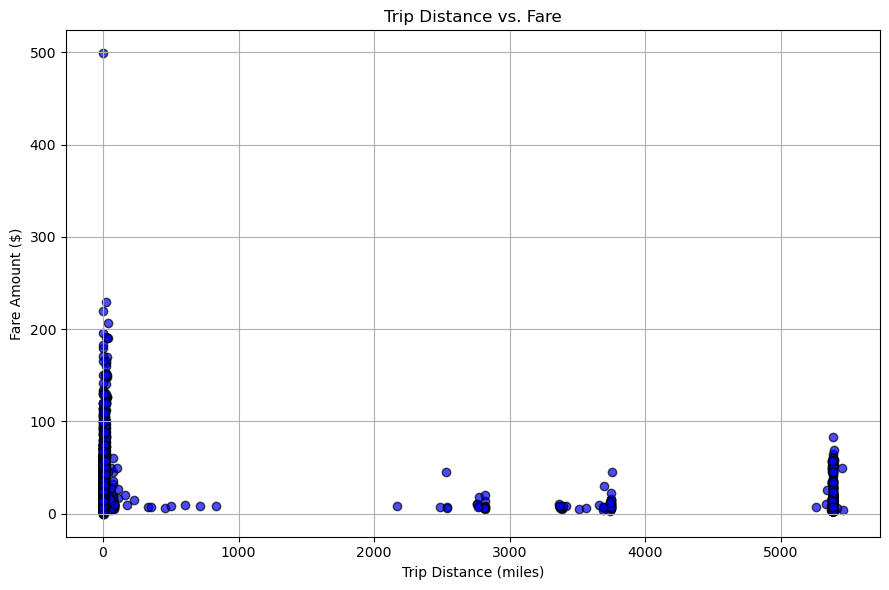

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data['trip_distance'], data['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Trip Distance vs. Fare')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

In [199]:
data = data[data['trip_distance'] < 1000]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193909 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        193909 non-null  float64
 1   pickup_longitude   193909 non-null  float64
 2   pickup_latitude    193909 non-null  float64
 3   dropoff_longitude  193909 non-null  float64
 4   dropoff_latitude   193909 non-null  float64
 5   passenger_count    193909 non-null  int64  
 6   pickup_year        193909 non-null  int32  
 7   pickup_month       193909 non-null  int32  
 8   pickup_day         193909 non-null  int32  
 9   pickup_hour        193909 non-null  int32  
 10  pickup_minute      193909 non-null  int32  
 11  pickup_second      193909 non-null  int32  
 12  trip_distance      193909 non-null  float64
dtypes: float64(6), int32(6), int64(1)
memory usage: 16.3 MB


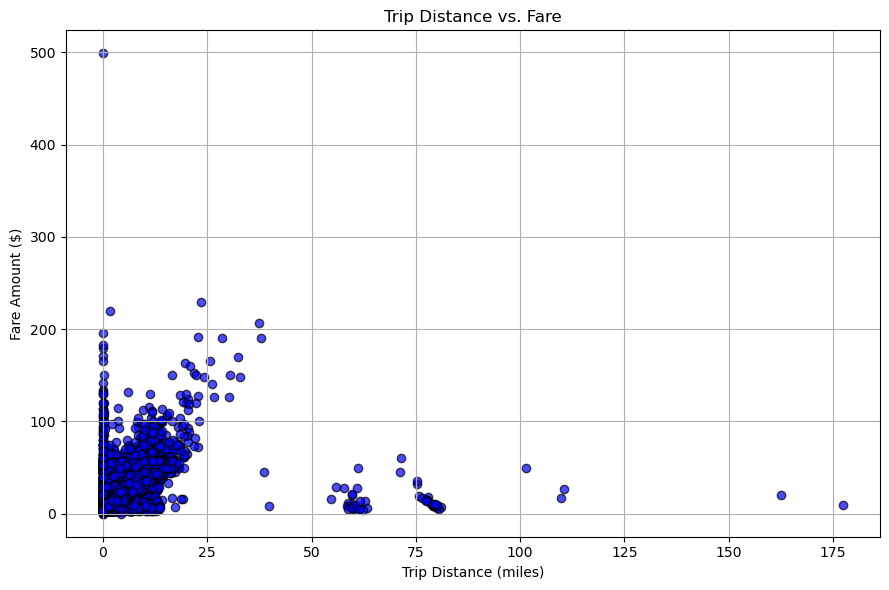

In [229]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data['trip_distance'], data['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Trip Distance vs. Fare')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

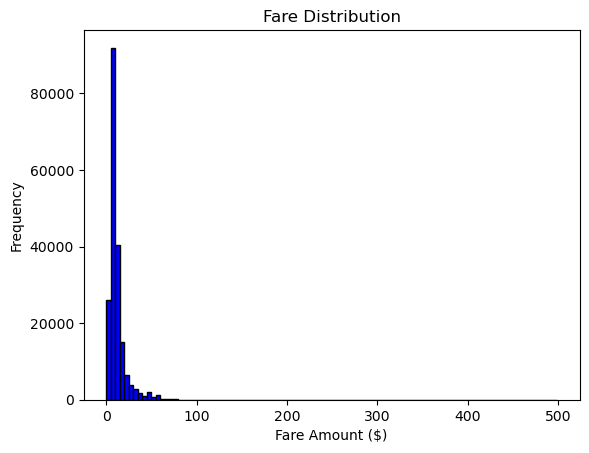

In [181]:
import matplotlib.pyplot as plt

plt.hist(data['fare_amount'], bins=100, color='blue', edgecolor='black')
plt.title('Fare Distribution')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

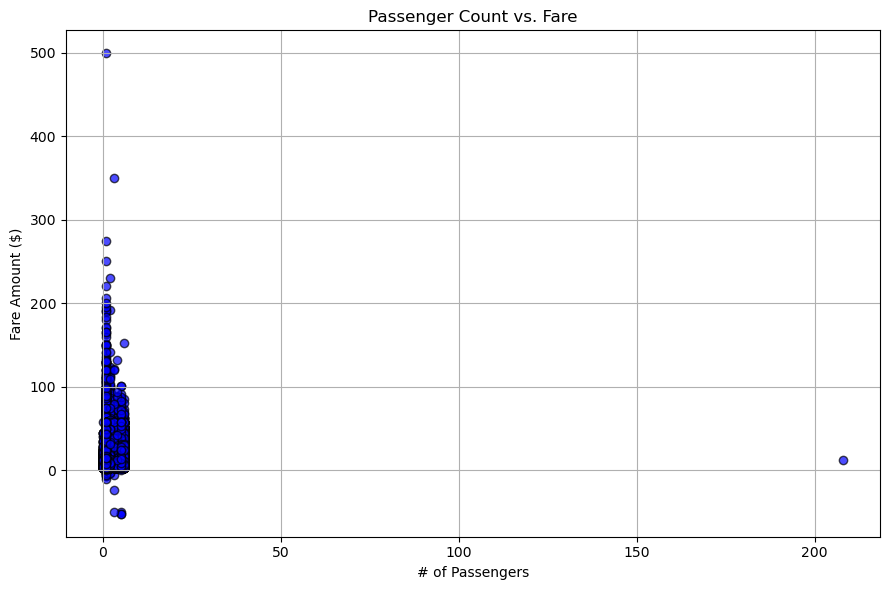

In [238]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data['passenger_count'], data['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Passenger Count vs. Fare')
plt.xlabel('# of Passengers')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

In [242]:
data = data[data['passenger_count'] < 50]
data = data[data['passenger_count'] > 0]

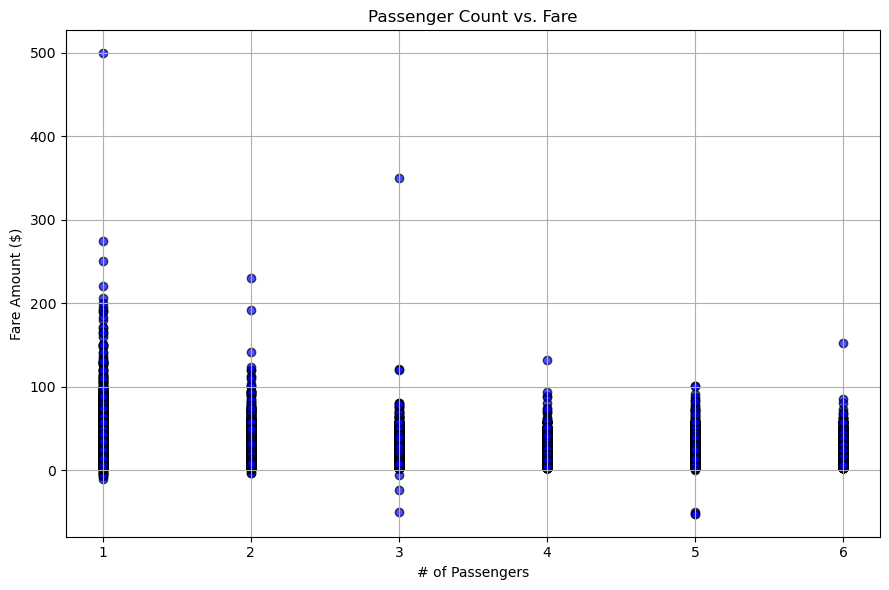

In [243]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data['passenger_count'], data['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Passenger Count vs. Fare')
plt.xlabel('# of Passengers')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

---

In [220]:
models_metrics = []

### Linear Regression

In [183]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_reg_model = LinearRegression()

lin_reg_model.fit(X_train, y_train)

y_pred = lin_reg_model.predict(X_test)

In [221]:
from sklearn.metrics import mean_squared_error, r2_score

linear_mse = mean_squared_error(y_test, y_pred)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, y_pred)
linear_r2 = lin_reg_model.score(X_test, y_test)

models_metrics.append({
    "model": "linear regression",
    "mse": linear_mse,
    "rmse": linear_rmse,
    "mae": linear_mae,
    "r2": linear_r2
})
print("linear regression")

print(f"mse: {linear_mse}")
print(f"rmse: {linear_rmse}")
print(f"mae: {linear_mae}")
print(f"R2: {linear_r2} ")

linear regression
mse: 26.94853488232173
rmse: 5.191197827315169
mae: 2.6584472817680607
R2: 0.014603165423860531 


### Ridge Regression w/ Cross Validation

In [186]:
from sklearn.linear_model import RidgeCV

k = 5

alphas = np.logspace(-3, 3, 10)

ridge_cv = RidgeCV(alphas=alphas, cv=k)
ridge_cv.fit(X_train, y_train)

y_pred = ridge_cv.predict(X_test)

In [222]:
ridge_mse = mean_squared_error(y_test, y_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, y_pred)
ridge_r2 = ridge_cv.score(X_test, y_test)

models_metrics.append({
    "model": "ridge regression",
    "mse": ridge_mse,
    "rmse": ridge_rmse,
    "mae": ridge_mae,
    "r2": ridge_r2
})

print("ridge regression")

print(f"mse: {ridge_mse}")
print(f"rmse: {ridge_rmse}")
print(f"mae: {ridge_mae}")
print(f"R2: {ridge_r2} ")

ridge regression
mse: 26.94853488232173
rmse: 5.191197827315169
mae: 2.6584472817680607
R2: 0.01460838922011709 


### Polynomial Regression

In [188]:
from sklearn.model_selection import cross_val_score
for d in range(2, 4):
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    scores = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    print(f"deg {d}, mean mse: {mean_score:.2f}")

deg 2, mean mse: 172.45
deg 3, mean mse: 1175596.42


In [189]:
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly2_train = poly2.fit_transform(X_train)

poly2_model = LinearRegression()
poly2_model.fit(X_poly2_train, y_train)

LinearRegression()

In [190]:
poly2_pred = poly2_model.predict(poly2.transform(X_test))

In [223]:
poly2_mse = mean_squared_error(y_test, poly2_pred)
poly2_rmse = np.sqrt(poly2_mse)
poly2_mae = mean_absolute_error(y_test, poly2_pred)
poly2_r2 = poly2_model.score(poly2.transform(X_test), y_test)

models_metrics.append({
    "model": "polynomial regression",
    "mse": poly2_mse,
    "rmse": poly2_rmse,
    "mae": poly2_mae,
    "r2": poly2_r2
})

print("polynomial regression")

print(f"mse: {poly2_mse}")
print(f"rmse: {poly2_rmse}")
print(f"mae: {poly2_mae}")
print(f"R2: {poly2_r2}")

polynomial regression
mse: 58.644850495052026
rmse: 7.657992589122297
mae: 4.393919022687575
R2: 0.3773878049803868


### Decision Tree Regression

In [192]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [118]:
dt_y_pred = dt.predict(X_test)

In [224]:
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, dt_y_pred)
dt_r2 = dt.score(X_test, y_test)

models_metrics.append({
    "model": "decision tree regression",
    "mse": dt_mse,
    "rmse": dt_rmse,
    "mae": dt_mae,
    "r2": dt_r2
})

print("decision tree regression")

print(f"mse: {dt_mse}")
print(f"rmse: {dt_rmse}")
print(f"mae: {dt_mae}")
print(f"R2: {dt.score(X_test, y_test)}")

decision tree regression
mse: 29.989002610589868
rmse: 5.476221563321728
mae: 2.6022884684653778
R2: 0.681617080029838


### Random Forest Regression

In [195]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [200]:
rf_y_pred = rf.predict(X_test)

In [225]:
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_r2 = rf.score(X_test, y_test)

models_metrics.append({
    "model": "random forest regression",
    "mse": rf_mse,
    "rmse": rf_rmse,
    "mae": rf_mae,
    "r2": rf_r2
})

print("random forest regression")

print(f"mse: {rf_mse}")
print(f"rmse: {rf_rmse}")
print(f"mae: {rf_mae}")
print(f"R2: {rf_r2}")

random forest regression
mse: 14.529806347705012
rmse: 3.811798308896342
mae: 1.8533562906296634
R2: 0.8457420464543977


### Extra Tree Regression

In [202]:
from sklearn.ensemble import ExtraTreesRegressor

n = {25, 50, 100, 200}
best_n = 0
best_score = 0

for i in n:
    et = ExtraTreesRegressor(n_estimators=i, max_depth=None, random_state=42)
    et.fit(X_train, y_train)

    et_y_pred = et.predict(X_test)

    if et.score(X_test, y_test) > best_score or best_n == 0:
        best_n = i
        best_score = et.score(X_test, y_test)
        et_model = et

print(f"best n: {best_n}")

best n: 200


In [203]:
et_y_pred = et_model.predict(X_test)

In [226]:
et_mse = mean_squared_error(y_test, et_y_pred)
et_rmse = np.sqrt(et_mse)
et_mae = mean_absolute_error(y_test, et_y_pred)
et_r2 = et_model.score(X_test, y_test)

models_metrics.append({
    "model": "extra trees regression",
    "mse": et_mse,
    "rmse": et_rmse,
    "mae": et_mae,
    "r2": et_r2
})

print("extra trees regression")

print(f"mse: {et_mse}")
print(f"rmse: {et_rmse}")
print(f"mae: {et_mae}")
print(f"R2: {et_model.score(X_test, y_test)}")

extra trees regression
mse: 17.440819590475893
rmse: 4.176220730573983
mae: 2.0074901716951685
R2: 0.8148368206841374


### Gradient Boosting Machines (GBM)

In [205]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=100,       
    learning_rate=0.1,      
    max_depth=6,         
    subsample=0.8,          
    colsample_bytree=0.8     
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [206]:
xgb_y_pred = xgb_model.predict(X_test)

In [227]:
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_r2 = xgb_model.score(X_test, y_test)

models_metrics.append({
    "model": "lightgbm regression",
    "mse": xgb_mse,
    "rmse": xgb_rmse,
    "mae": xgb_mae,
    "r2": xgb_r2
})

print("lightgbm regression")

print(f"mse: {xgb_mse}")
print(f"rmse: {xgb_rmse}")
print(f"mae: {xgb_mae}")
print(f"R2: {xgb_r2}")

lightgbm regression
mse: 15.157727396693305
rmse: 3.8932926163715598
mae: 1.8457796218572675
R2: 0.8390756247769717


### Adaboost Regression

In [228]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

base_estimator = DecisionTreeRegressor(max_depth=4)
adaboost_model = None

best_n = 0
best_score = 0

n={5, 7, 9, 10, 25, 50, 100}

for i in n:
    curr_adaboost_model = AdaBoostRegressor(
        estimator=base_estimator,  
        n_estimators=i,              
        learning_rate=0.1,             
        loss='square',                
        random_state=42                
    )

    curr_adaboost_model.fit(X_train, y_train)
    y_pred = curr_adaboost_model.predict(X_test)

    score = curr_adaboost_model.score(X_test, y_test)
    print(f"n_estimators: {i}, R2: {score}")

    if curr_adaboost_model.score(X_test, y_test) > best_score or best_n == 0:
        best_n = i
        best_score = curr_adaboost_model.score(X_test, y_test)
        adaboost_model = curr_adaboost_model

print(f"best n: {best_n}")

adaboost_model.fit(X_train, y_train)

n_estimators: 50, R2: 0.7478321095893066
n_estimators: 100, R2: 0.6525495480945154
n_estimators: 5, R2: 0.7505516157959077
n_estimators: 7, R2: 0.7212724733675113
n_estimators: 9, R2: 0.7195549646561048
n_estimators: 10, R2: 0.7204648335862867
n_estimators: 25, R2: 0.7138966795207267
best n: 5


AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4),
                  learning_rate=0.1, loss='square', n_estimators=5,
                  random_state=42)

In [209]:
adaboost_y_pred = adaboost_model.predict(X_test)

In [230]:
adaboost_mse = mean_squared_error(y_test, adaboost_y_pred)
adaboost_rmse = np.sqrt(adaboost_mse)
adaboost_mae = mean_absolute_error(y_test, adaboost_y_pred)
adaboost_r2 = adaboost_model.score(X_test, y_test)

models_metrics.append({
    "model": "adaboost regression",
    "mse": adaboost_mse,
    "rmse": adaboost_rmse,
    "mae": adaboost_mae,
    "r2": adaboost_r2
})

print("adaboost regression")

print(f"mse: {adaboost_mse}")
print(f"rmse: {adaboost_rmse}")
print(f"mae: {adaboost_mae}")
print(f"R2: {adaboost_r2}")

adaboost regression
mse: 23.495947099816217
rmse: 4.847261814655385
mae: 2.4827155981063336
R2: 0.7505516157959077


---

### ALL MODELS & METRICS

In [231]:
for model in models_metrics:
    print(model['model'])

    print(f"mse: {model['mse']}")
    print(f"rmse: {model['rmse']}")
    print(f"mae: {model['mae']}")
    print(f"R2: {model['r2']}")
    print("\n")

linear regression
mse: 26.94853488232173
rmse: 5.191197827315169
mae: 2.6584472817680607
R2: 0.014603165423860531


ridge regression
mse: 26.94853488232173
rmse: 5.191197827315169
mae: 2.6584472817680607
R2: 0.01460838922011709


polynomial regression
mse: 58.644850495052026
rmse: 7.657992589122297
mae: 4.393919022687575
R2: 0.3773878049803868


decision tree regression
mse: 29.989002610589868
rmse: 5.476221563321728
mae: 2.6022884684653778
R2: 0.681617080029838


random forest regression
mse: 14.529806347705012
rmse: 3.811798308896342
mae: 1.8533562906296634
R2: 0.8457420464543977


extra trees regression
mse: 17.440819590475893
rmse: 4.176220730573983
mae: 2.0074901716951685
R2: 0.8148368206841374


lightgbm regression
mse: 15.157727396693305
rmse: 3.8932926163715598
mae: 1.8457796218572675
R2: 0.8390756247769717


adaboost regression
mse: 23.495947099816217
rmse: 4.847261814655385
mae: 2.4827155981063336
R2: 0.7505516157959077




### Comparing MSE

In [232]:
mse_sorted = sorted(models_metrics, key=lambda x: x['mse'])

for model in mse_sorted:
    print(model['model'])
    print(f"mse: {model['mse']}")
    print("\n")

random forest regression
mse: 14.529806347705012


lightgbm regression
mse: 15.157727396693305


extra trees regression
mse: 17.440819590475893


adaboost regression
mse: 23.495947099816217


linear regression
mse: 26.94853488232173


ridge regression
mse: 26.94853488232173


decision tree regression
mse: 29.989002610589868


polynomial regression
mse: 58.644850495052026




### Comparing RMSE

In [233]:
rmse_sorted = sorted(models_metrics, key=lambda x: x['rmse'])

for model in rmse_sorted:
    print(model['model'])
    print(f"rmse: {model['rmse']}")
    print("\n")

random forest regression
rmse: 3.811798308896342


lightgbm regression
rmse: 3.8932926163715598


extra trees regression
rmse: 4.176220730573983


adaboost regression
rmse: 4.847261814655385


linear regression
rmse: 5.191197827315169


ridge regression
rmse: 5.191197827315169


decision tree regression
rmse: 5.476221563321728


polynomial regression
rmse: 7.657992589122297




### Comparing MAE

In [234]:
mae_sorted = sorted(models_metrics, key=lambda x: x['mae'])

for model in mae_sorted:
    print(model['model'])
    print(f"mae: {model['mae']}")
    print("\n")

lightgbm regression
mae: 1.8457796218572675


random forest regression
mae: 1.8533562906296634


extra trees regression
mae: 2.0074901716951685


adaboost regression
mae: 2.4827155981063336


decision tree regression
mae: 2.6022884684653778


linear regression
mae: 2.6584472817680607


ridge regression
mae: 2.6584472817680607


polynomial regression
mae: 4.393919022687575




### Comparing R2 Scores

In [235]:
r2_sorted = sorted(models_metrics, key=lambda x: x['r2'], reverse=True)

for model in r2_sorted:
    print(model['model'])
    print(f"r2: {model['r2']}")
    print("\n")

random forest regression
r2: 0.8457420464543977


lightgbm regression
r2: 0.8390756247769717


extra trees regression
r2: 0.8148368206841374


adaboost regression
r2: 0.7505516157959077


decision tree regression
r2: 0.681617080029838


polynomial regression
r2: 0.3773878049803868


ridge regression
r2: 0.01460838922011709


linear regression
r2: 0.014603165423860531




### Best Model

In [236]:
print("best model: " + r2_sorted[0]['model'])

print(f"mse: {r2_sorted[0]['mse']}")
print(f"rmse: {r2_sorted[0]['rmse']}")
print(f"mae: {r2_sorted[0]['mae']}")
print(f"R2: {r2_sorted[0]['r2']}")

best model: random forest regression
mse: 14.529806347705012
rmse: 3.811798308896342
mae: 1.8533562906296634
R2: 0.8457420464543977
